In [1]:
# Using this because setup.py is not working
import sys

sys.path.append("../../")
import sys

sys.path.append("../data/")

import O2_FEV1_df
import patient_data

from partition import *
from desaturation_fev1 import *
from normalise import *
from exacerbation_periods import *
from smooth import *
from plot_helpers import *
from biology import *
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go


# Settings
plotsdir = "../../../../PlotsSmartcare/O2_FEV1/"


In [2]:
# Process O2-FEV1 data
O2_FEV1 = O2_FEV1_df.create()



** Loading measurements data **


/Users/tristan.trebaol/Desktop/PhD/Code/phd/src/O2-FEV1 analysis/../data/measurements_data.py:101: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(datadir + "mydata.csv")



* Dropping unnecessary columns from measurements data *
Columns filtered ['User ID', 'UserName', 'Recording Type', 'Date/Time recorded', 'FEV 1', 'Weight in Kg', 'O2 Saturation', 'Pulse (BPM)', 'Rating', 'Temp (deg C)']
Dropping columns {'Predicted FEV', 'Sputum sample taken?', 'Activity - Points', 'Calories', 'FEV 10', 'FEV 1 %', 'Activity - Steps'}

* Renaming columns *
Renamed columns {'Date/Time recorded': 'Date recorded', 'FEV 1': 'FEV1', 'Weight in Kg': 'Weight (kg)'}

* Applying data sanity checks *

FEV1
Dropping 1 entries with FEV1 = 3.45 for user Kings004

Weight (kg)
Dropping 2 entries with Weight (kg) = 6.0 for user Papworth033
Dropping 1 entries with Weight (kg) = 0.55 for user Kings013
Dropping 1 entries with Weight (kg) = 8.262500000000001 for user Papworth017
Dropping 1 entries with Weight (kg) = 1056.0 for user leeds01730
Dropping 1 entries with Weight (kg) = 20.0 for user Papworth019
Warning - ID PapworthSummer has Weight (28.9375) outside 30-122 kg range
Warning - I

/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():



* Dropping unnecessary columns from antibiotics data *
Columns filetered: ['ID', 'Antibiotic Name', 'Route', "Home IV's'", 'Start Date', 'Stop Date']
Columns dropped: {'Hospital', 'Antibiotic ID', 'Study Number'}

** Creating DataFrame for O2 FEV1 analysis **
O2 Saturation has 14011 measurements
FEV1 has 9936 measurements
Merged O2 and FEV1 into 9526 entries (initially 14421, removed 4895 NaN)
Asserting that there's only one measurement per ID per day

Created df_O2_FEV1 with 9526 entries (initially 14421, removed 4895)


In [3]:
# What are we analysing?
# Get the number of measurements per patient in O2_FEV1
counts = (
    O2_FEV1.groupby("ID")
    .count()
    .sort_values(by="FEV1", ascending=False)
    .reset_index()[["ID", "Date recorded"]]
)
# Rename date recorded to count
counts.rename(columns={"Date recorded": "Count"}, inplace=True)
# Bar plot of counts with ID on x-axis and "Date recorded" on y-axis
fig = px.bar(counts, x="ID", y="Count", title="Number of measurements per patient")
fig.show()


# O2-FEV1 analysis
## Definitions
- O2 Saturation
- FEV 1
- Predicted FEV 1 in %: measure for the amount of airway obstruction either due to sputum load (non-permanent obstruction) or scars in the lungs (permanent obstruction).

## Literature
[The association between forced expiratory volume in one second (FEV1) and pulse oximetric measurements of arterial oxygen saturation (SpO2) in the patients with COPD: A preliminary study](https://pubmed.ncbi.nlm.nih.gov/24949035/).
- Context: 31 patients with COPD
- Key results: There was not statistically significant correlation between FEV1 % predicted and SpO2 values (P < 0.05), but a great correlation existed between FEV1/FVC % predicted and SpO2 values (r = 0.556, P < 0.001).

 [ANALYSIS OF CORRELATION BETWEEN FEV1/FEV6 AND OXYGEN SATURATION DURING SIX-MINUTE WALK TEST (6MWT) IN COPD PATIENTS](https://www.researchgate.net/publication/351322676_ANALYSIS_OF_CORRELATION_BETWEEN_FEV1FEV6_AND_OXYGEN_SATURATION_DURING_SIX-MINUTE_WALK_TEST_6MWT_IN_COPD_PATIENTS)
 - Need to download

Note: nobody segments the input by groups. Probably because they don't have enough data to do this.

## Raw scatter plots

In [5]:
# Raw plot without trendline
fig = px.scatter(O2_FEV1, y="O2 Saturation", x="FEV1")
# fig = px.scatter(O2_FEV1, y="O2 Saturation", x="FEV1", trendline="ols")
fig.update_layout(autosize=False, width=500, height=500)
fig.show()
fig.write_image(plotsdir + "FEV1-O2 raw.pdf")

fig = px.scatter(O2_FEV1, y="O2 Saturation", x="FEV1 % Predicted")
fig.update_layout(autosize=False, width=500, height=500)
fig.show()
# fig.write_image(plotsdir + "FEV1 % Predicted-O2 raw.pdf")

O2_FEV1.shape

(9526, 12)

In [5]:
var = "FEV1"
xaxis_range = [0, 5.1]
# var = 'FEV1 % Predicted'; xaxis_range = [0, 155]

# Plot with height
O2_FEV1["Height Group"], height_labels = partition_in_n_equal_groups(
    O2_FEV1["Height"], 3, True
)

fig = px.scatter(
    O2_FEV1,
    y="O2 Saturation",
    x=var,
    color="Height Group",
    marginal_x="histogram",
    marginal_y="histogram",
)
# fig.update_layout(autosize=False, width=800, height=800)
fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
# fig.update_xaxes(range=[0.9*min(O2_FEV1["FEV1"]), 1.1*max(O2_FEV1["FEV1"])])
# fig.update_yaxes(range=[0.9*min(O2_FEV1["O2 Saturation"]), max(1.1*O2_FEV1["O2 Saturation"])])
# fig.show()
# Partition FEV1 % Predicted in 3 groups

for height_group in height_labels:
    mask_height = O2_FEV1["Height Group"] == height_group

    fig = px.scatter(
        O2_FEV1[mask_height],
        y="O2 Saturation",
        x=var,
        title="Height group {}".format(height_group),
    )
    fig.update_layout(autosize=False, width=500, height=500)
    fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
    fig.update_xaxes(range=xaxis_range)
    fig.update_yaxes(range=[74, 102])
    fig.show()
    filename = "Height group " + height_group + " " + var + "-O2 raw"
    fig.write_image(plotsdir + filename + ".pdf")


In [7]:
predicted = True
x_var = "Height"
lung_function_var = "FEV1 % Predicted" if predicted else "FEV1"

fig1, fig2, _ = desaturation_FEV1_for_variable(
    O2_FEV1, x_var, n_var_groups=6, predicted=predicted
)
fig1.show()
fig1.write_image(
    plotsdir + "Desaturation {} for {} main plot.pdf".format(lung_function_var, x_var)
)

fig2.show()

fig2.write_image(
    plotsdir + "Desaturation {} for {} with lines.pdf".format(lung_function_var, x_var)
)

# Observations
# o2 10, var 15 contains a lot of noise and groups have very low number of datapoints. It gets too patient specific


## Per patient plots

In [3]:
# Same patient variability: can we observe the same pattern for each patient?
O2_FEV1.head()


# Include time evolution into the graph
def to_float(dt_time):
    return (365 * dt_time.year + 12 * dt_time.month + dt_time.day) / 12


mindate = to_float(min(O2_FEV1["Date recorded"]))
O2_FEV1["Months since study start"] = O2_FEV1["Date recorded"].apply(
    lambda x: to_float(x) - mindate
)


In [ ]:
# Same patient variability: can we observe the same pattern for each patient?
IDs = O2_FEV1.ID.unique()
for ID in IDs:
    plot_o2_fev1_raw_for_id(O2_FEV1, ID)


## Summary plot (+ partitioning)

In [4]:
O2_FEV1


,ID,Date recorded,O2 Saturation,FEV1,Study Date,DOB,Age,Sex,Height,Weight,Predicted FEV1,FEV1 % Predicted
0,23,2015-08-12,95.0,1.49,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265,66.921177
1,138,2015-08-14,94.0,1.30,2015-08-06,1985-10-31,30,Male,172.0,66.6,4.0360,32.210109
2,23,2015-08-14,95.0,1.29,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265,57.938468
3,23,2015-08-21,94.0,1.35,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265,60.633281
4,137,2015-08-26,95.0,1.28,2015-08-25,1976-05-24,39,Female,172.0,61.0,3.2190,39.763902
...,...,...,...,...,...,...,...,...,...,...,...,...
9521,172,2017-03-23,95.0,0.81,2016-09-27,1991-06-18,25,Female,159.0,51.4,3.0555,26.509573
9522,179,2017-03-28,97.0,1.72,2016-10-21,1975-02-21,42,Female,168.0,57.9,2.9860,57.602143
9523,227,2017-04-01,95.0,1.99,2016-10-07,1970-05-15,46,Male,176.5,73.2,3.7655,52.848227
9524,229,2017-04-04,95.0,0.71,2016-10-27,1973-01-11,44,Female,151.0,50.0,2.2645,31.353500


In [6]:
# Add exacerbated labels
remove_no_ex_ids = True
# Compute exacerbation labels
# O2_FEV1_processed = compute_ex_labels_from_heuristics(antibioticsdata, patientsdata, O2_FEV1)

# Get exacerbation labels from the predictive classifier
O2_FEV1_processed = merge_pred_ex_labels_to(O2_FEV1, get_pred_ex_labels())

# Removing patient with no ex during the study
if remove_no_ex_ids:
    O2_FEV1_processed = patient_data.drop_where_no_ex_ids(O2_FEV1_processed)

Exacerbated labels data from the predictive classifier has 14452 entries (1445 exacerbated, 13006 not exacerbated measurements, 1 NaN)
** Inner merge of O2_FEV1 and exacerbated labels on 'ID' and 'Date recorded' **
Data has now 7995 entries and 103 IDs (initially 9526 & 146 in O2_FEV1, 14452 in pred_ex_labels)
Dropping individuals that did not have an exacerbation/antibiotic treatment
Data has now 4883 entries and 70 ids (initially 7995 & 103)


In [8]:
# Smooth
O2_FEV1_processed = smooth(O2_FEV1_processed, ["FEV1", "FEV1 % Predicted"], mode="max")
O2_FEV1_processed = smooth(O2_FEV1_processed, ["O2 Saturation"], mode="mean")
print(
    "Removed {} nan entries after max smoothing, kept {}".format(
        O2_FEV1_processed.isna().sum().max(), O2_FEV1_processed.shape[0]
    )
)
O2_FEV1_processed.dropna(inplace=True)

# Normalise
O2_FEV1_processed = norm_by_stable_baseline(
    O2_FEV1_processed,
    [
        "O2 Saturation",
        "O2 Saturation smoothed",
        "FEV1",
        "FEV1 % Predicted",
        "FEV1 smoothed",
        "FEV1 % Predicted smoothed",
    ],
)

# Settings
prefix, ex_column, x, y = set_x_y_vars(
    with_predicted_labels=True,
    with_predicted_fev1=False,
    is_smoothed_fev=True,
    is_smoothed_o2=False,
    is_normalised=False,
)

title = "Ex labels {} {}-{}, {}.pdf".format(
    prefix, x, y, "removed no ex IDs" if remove_no_ex_ids else ""
)

is_partitioned = False
if not is_partitioned:
    # Plot O2-FEV with respective displots
    fig = plot_o2_fev_with_displots(O2_FEV1_processed, x, y, ex_column, title)
    fig.show()
    fig.write_image(
        "{}/title.pdf".format(plotsdir),
        width=1400,
        height=600,
    )

    # Plot subsampled O2-FEV scatter
    fig = plot_subsampled_scatter(x, y, O2_FEV1_processed, random_state=7)
    fig.show()

else:
    # Use partitioned data. Note that this requires smoothed True and Predicted FEV1 False

    predicted_fev1_thresholds = [2.4, 3.2, 4]

    # Print number of uniaue ID
    print(
        "There are {} different individuals".format(len(O2_FEV1_processed.ID.unique()))
    )

    # Filter by unique ID
    O2_FEV1_processed = O2_FEV1_processed.groupby("ID").filter(lambda l: len(l) > 1)
    # Check if individual's Predicted FEV1 position wrt to groups thresholds
    O2_FEV1_processed["Predicted FEV1 Group"] = O2_FEV1_processed[
        "Predicted FEV1"
    ].apply(lambda l: value_to_group(l, predicted_fev1_thresholds))

    # Create a for loop for each Group
    # parition_variable = 'FEV1 % Predicted smoothed'
    parition_variable = "Predicted FEV1"

    for fev_group in O2_FEV1_processed[parition_variable + " Group"].unique():
        mask = O2_FEV1_processed[parition_variable + " Group"] == fev_group
        # Count patients
        n_patients = len(O2_FEV1_processed[mask].ID.unique())

        # Plot scatter plot using plotly with O2_FEV1_processed[mask], x, y, ex_column with color from get_ex_color() and get_stable_color()
        fig = px.scatter(
            O2_FEV1_processed[mask],
            x=x,
            y=y,
            color=ex_column,
            color_discrete_sequence=[get_stable_color(), get_ex_color()],
        )
        # Set x axes range to min max of O2_FEV1_processed[x]
        fig.update_xaxes(
            range=[O2_FEV1_processed[x].min() * 0.95, O2_FEV1_processed[x].max() * 1.05]
        )
        fig.update_layout(
            title="{} patients, {} {}".format(n_patients, parition_variable, fev_group)
        )

        fig.show()
        fig.write_image(
            "{}/Ex labels {} {}-{} group {}.pdf".format(
                plotsdir, prefix, x, y, fev_group
            ),
            width=1400,
            height=600,
        )

# Save O2_FEV1_processed to excel file in plotsdir
O2_FEV1_processed.to_excel(plotsdir + "O2_FEV1_processed.xlsx")

Removed 0 nan entries after max smoothing, kept 4882


## Test the sensitivity of random states on subsampled plots
We wonder if different random states will give largely different results, to an extend that it could challenge the model assumptions.
It turns out that, despite an effect on the x axis range, the subsampled plots are very similar.

In [ ]:
# Add subsampled plot
prefix, ex_column, x, y = set_x_y_vars(
    with_predicted_labels=True,
    with_predicted_fev1=True,
    is_smoothed=True,
    is_normalised=False,
)

for random_state in range(1, 10):
    print(random_state)
    fig = plot_subsampled_scatter(x, y, O2_FEV1_processed, random_state=random_state)
    fig.show()


## Full sized displots

In [ ]:
# This part fo the code is unused now
# But the displots can be useful for the report, so I keep it here

if predicted:
    if normalised:
        xrange = [-1.8, 1.2]
    else:
        xrange = [0, 155]
    bin_size = 4
else:
    if normalised:
        xrange = [-42, 40]
    else:
        xrange = [0, 5.1]
    bin_size = 0.14

# Raw plot with superposed exacerbation labels
fig = px.scatter(O2_FEV1_processed, y=y, x=x, color=ex_column)
# fig.update_layout(autosize=False, width=800, height=800)
fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
# fig.show()
# fig.write_image("{}/{}-{} by exacerbated labels superposed raw.pdf".format(plotsdir, x, y))

# Raw individual plot for each exacerbation label]
fig_scatter = px.scatter(
    O2_FEV1_processed.dropna(),
    y=y,
    x=x,
    # color='Exacerbation Labels',
    facet_col=ex_column,
)
fig_scatter.update_layout(autosize=False, width=1000, height=500)
fig_scatter.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
# fig_scatter.update_xaxes(range=xrange)
if not (normalised):
    fig_scatter.update_yaxes(range=[74, 102])
# fig_scatter.show()
# fig.write_image("{}/Ex labels {} {}-{} individual raw.pdf".format(plotsdir, prefix, x, y), width=1300, height=400)


def distplot(x, group_labels, bin_size):
    data = []
    for exacerbation_label in group_labels:
        mask = O2_FEV1_processed[ex_column] == exacerbation_label
        data.append(O2_FEV1_processed[x][mask])
        print(
            "{} measurements with {} = {}".format(
                sum(mask), ex_column, exacerbation_label
            )
        )
    fig = ff.create_distplot(data, group_labels, bin_size=bin_size, show_rug=False)
    fig.update_xaxes(title_text=x)
    fig.update_layout(autosize=False, width=1000, height=400)
    return fig


# Create distplot for x = lung function
group_labels = (
    [True, False] if with_predicted_labels else ["Exacerbation Period", "Stable Period"]
)
fig_distplot_fev1 = distplot(x, group_labels, bin_size)
fig_distplot_fev1.show()
# fig.write_image("{}/Ex labels {} {} distplot.pdf".format(plotsdir, prefix, x), width=1000, height=400)

# Create distplot for y = O2 saturation
group_labels = (
    [True, False] if with_predicted_labels else ["Exacerbation Period", "Stable Period"]
)
fig_displot_o2 = distplot(y, group_labels, 1)
fig_displot_o2.show()
# fig_displot_o2.write_image("{}/Ex labels {} {} distplot.pdf".format(plotsdir, prefix, y), width=1000, height=400)


## Patient level plots to validate or validate outliers down

In [20]:
O2_FEV1_processed


,ID,Date recorded,O2 Saturation,FEV1,Study Date,DOB,Age,Sex,Height,Weight,...,Is Exacerbated,FEV1 smoothed,FEV1 % Predicted smoothed,O2 Saturation smoothed,O2 Saturation norm,O2 Saturation smoothed norm,FEV1 norm,FEV1 % Predicted norm,FEV1 smoothed norm,FEV1 % Predicted smoothed norm
757,100,2015-12-14,97.0,2.81,2015-12-14,1990-08-10,25,Female,173.0,55.2,...,False,2.81,77.871692,97.000000,-0.200000,-0.244444,0.330667,9.163549,0.113333,3.140733
776,100,2015-12-15,96.0,2.25,2015-12-14,1990-08-10,25,Female,173.0,55.2,...,False,2.69,74.546210,97.333333,-1.200000,0.088889,-0.229333,-6.355365,-0.006667,-0.184749
1106,100,2015-12-16,98.0,2.69,2015-12-14,1990-08-10,25,Female,173.0,55.2,...,False,2.69,74.546210,97.333333,0.800000,0.088889,0.210667,5.838068,-0.006667,-0.184749
931,100,2015-12-17,98.0,2.54,2015-12-14,1990-08-10,25,Female,173.0,55.2,...,False,2.69,74.546210,97.333333,0.800000,0.088889,0.060667,1.681216,-0.006667,-0.184749
825,100,2015-12-19,96.0,2.15,2015-12-14,1990-08-10,25,Female,173.0,55.2,...,False,2.69,74.546210,97.333333,-1.200000,0.088889,-0.329333,-9.126599,-0.006667,-0.184749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4350,99,2016-06-07,96.0,3.36,2015-12-15,1983-04-22,33,Male,171.0,69.6,...,False,3.36,86.021505,96.666667,0.526316,1.192982,0.127763,3.270946,0.046382,1.187444
4361,99,2016-06-08,97.0,3.16,2015-12-15,1983-04-22,33,Male,171.0,69.6,...,False,3.36,86.021505,96.000000,1.526316,0.526316,-0.072237,-1.849382,0.046382,1.187444
4390,99,2016-06-09,95.0,3.30,2015-12-15,1983-04-22,33,Male,171.0,69.6,...,False,3.30,84.485407,96.333333,-0.473684,0.859649,0.067763,1.734848,-0.013618,-0.348654
4429,99,2016-06-10,97.0,3.28,2015-12-15,1983-04-22,33,Male,171.0,69.6,...,False,3.30,84.485407,95.666667,1.526316,0.192982,0.047763,1.222815,-0.013618,-0.348654


In [19]:
# O2-FEV1: Outliers down can happen, however if you are persistently getting low reading it means that it's not an outlier
# Checking O2 sat stable period measurements outliers
exacerbation_label = "Stable Period"

# Case 1:
IDs = ["180", "202"]
o2_saturation_threshold = 87

# Case 2: smoothed
o2_saturation_threshold = 90

# Plot
ids = O2_FEV1_processed[
    (O2_FEV1_processed["Exacerbation Labels"] == exacerbation_label)
    & (O2_FEV1_processed["O2 Saturation"] < o2_saturation_threshold)
].ID.unique()
print(ids)
for id in ids:
    plot_o2_fev1_raw_for_id(O2_FEV1_processed, id, save=False, show=True)


KeyError: 'Exacerbation Labels'

## Validate smooth max

In [34]:
def plot_fev1_and_fev1_smoothed_for_id(O2_FEV1, id):
    O2_FEV1 = O2_FEV1[O2_FEV1["ID"] == id]

    mode = "max"
    O2_FEV1 = smooth(O2_FEV1, ["FEV1"], mode=mode)

    # Plot
    # Create a subplots that share the same x and y axes with plotly
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)
    # Add scatter of FEV1 with Date recorded with a name 'FEV1' with marker opacity
    fig.add_scatter(
        x=O2_FEV1["Date recorded"],
        y=O2_FEV1["FEV1"],
        mode="markers+lines",
        name="FEV1",
        opacity=0.5,
        row=1,
        col=1,
        marker=dict(size=5),
        line=dict(width=1),
    )
    # Add scatter of FEV1 smoothed with Date recorded with a name 'FEV1 smoothed'
    fig.add_scatter(
        x=O2_FEV1["Date recorded"],
        y=O2_FEV1["FEV1 smoothed"],
        mode="markers+lines",
        name="FEV1 smoothed",
        opacity=1,
        row=1,
        col=1,
        marker=dict(size=5),
        line=dict(width=1),
    )
    # Update figure size
    fig.update_layout(
        autosize=False,
        width=1000,
        height=300,
        title="FEV1 and FEV1 smoothed for ID {}".format(id),
        yaxis_title="Volume (L)",
    )
    fig.show()


# Plot plot_fev1_and_fev1_smoothed_for_id for the first 10 IDs of O2_FEV1
for id in O2_FEV1.ID.unique()[:10]:
    plot_fev1_and_fev1_smoothed_for_id(O2_FEV1, id)


## How to smooth O2?

In [ ]:
# Plots O2 saturation against Date for a given patient id
def plot_o2_saturation_for_id(df, id, plotsdir, save=False, show=False):
    mask = df["ID"] == id
    fig = px.scatter(df[mask], x="Date recorded", y="O2 Saturation")
    fig.update_layout(autosize=False, width=1000, height=400)
    fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
    if save:
        fig.write_image(
            "{}/O2 for ID/O2 saturation for ID {}.pdf".format(plotsdir, id),
            width=1000,
            height=400,
        )
    if show:
        fig.show()


# For each patient id, plot O2 saturation against Date recorded
for id in O2_FEV1.ID.unique():
    plot_o2_saturation_for_id(O2_FEV1, id, plotsdir, save=True, show=False)


## Why are there measurements with FEV1 % Pred smoothed > 70% and FEV1 smoothed < 1L?
image.png
The scatter plot of O2 vs FEV1 for the FEV1 % Predicted group between 70% and 90% shows several measurements with an FEV1 smoothed below 1L. This looks erroneous.
There are 98 measurements with FEV1 % Pred smoothed > 70% and FEV1 smoothed < 1L. 
- 92 measurements belong to individual with ID 216. There are no other measurements for this individual. Is there a problem for the data collected by this individual?

Action: add function `remove_all_measurements_with_ID_216()`

In [ ]:
114 * 0.01 * 3.95 - 44 * 0.025 - 2.6

In [ ]:
# Find rows where FEV1 % Predicted smoothed > 70% and FEV1 smoothed < 1 L
mask = (O2_FEV1_processed["FEV1 % Predicted smoothed"] > 70) & (
    O2_FEV1_processed["FEV1 smoothed"] < 1
)
print(
    "{} measurements with FEV1 % Predicted smoothed > 70% and FEV1 < 1 L".format(
        sum(mask)
    )
)
# Set pandas display max row option to 100
# pd.set_option('display.max_rows', 100)
# Apply the mask and filter the folowing columns ID, FEV1, FEV1 smoothed, Age, Sex, Height, Weight, FEV1 % Predicted, FEV1 % Predicted smoothed, Is Exacerbated
O2_FEV1_processed[mask][
    [
        "ID",
        "Age",
        "Sex",
        "Height",
        "Weight",
        "FEV1",
        "FEV1 smoothed",
        "Predicted FEV1",
        "Predicted FEV1",
        "FEV1 % Predicted",
        "FEV1 % Predicted smoothed",
        "Is Exacerbated",
        "O2 Saturation",
    ]
].sort_values(by=["ID", "FEV1 % Predicted smoothed"])


In [ ]:
# Filter measurements done by ID 216
mask = O2_FEV1_processed["ID"] == "216"

# Add scatter of FEV1 smoothed against date recorded
fig = px.scatter(O2_FEV1_processed[mask], x="Date recorded", y="FEV1 smoothed")
# Add scatter of FEV1 with trace name FEV1
fig.add_scatter(
    x=O2_FEV1_processed[mask]["Date recorded"],
    y=O2_FEV1_processed[mask]["FEV1"],
    mode="markers",
    name="FEV1",
)
fig.show()
# Apply the mask and filter the folowing columns ID, FEV1, FEV1 smoothed, Age, Sex, Height, Weight, FEV1 % Predicted, FEV1 % Predicted smoothed, Is Exacerbated
O2_FEV1_processed[mask][
    [
        "ID",
        "Date recorded",
        "FEV1",
        "FEV1 smoothed",
        "Age",
        "Sex",
        "Height",
        "Weight",
        "FEV1 % Predicted",
        "FEV1 % Predicted smoothed",
        "Is Exacerbated",
    ]
].sort_values(by=["FEV1 smoothed"])


## Predictive classifier

#### Predictive classifier
* 90% of the measurements are labelled as "stable"
* 50% of the data from the predictive classifier belongs to individuals that did not have any exacerbation

In [46]:
# Are missing smartcare IDs from the ID mapping table, present in the pred classifier table?

# IDs that are present in the pred classifier table, but absent in the O2_FEV1 table
df_pred = get_pred_ex_labels()
pred_ids = df_pred.reset_index().ID.unique()

mapping_ids = O2_FEV1.ID.unique()

# Find elements in pred_ids that are not in mapping_ids
np.setdiff1d(pred_ids, mapping_ids)


Exacerbated labels data from the predictive classifier has 14452 entries (1445 exacerbated, 13006 not exacerbated measurements, 1 NaN)


array([], dtype=object)

In [105]:
# Are there any individuals with no exacerbation labels?
df_pred = merge_pred_ex_labels_to(O2_FEV1, get_pred_ex_labels())
df_pred_ex = df_pred[df_pred["Is Exacerbated"] == True]
df_pred_stable = df_pred[df_pred["Is Exacerbated"] == False]
ids_ex = df_pred_ex.ID.unique()
ids_stable = df_pred_stable.ID.unique()

print("{} IDs with exacerbated labels".format(ids_ex.size))
print("{} IDs with stable labels".format(ids_stable.size))


ids_stable_but_no_ex = np.setdiff1d(ids_stable, ids_ex)

print(
    "IDs with stable labels but no exacerbation labels: {}".format(ids_stable_but_no_ex)
)


# Let's check what's the amount belonging to individuals that have stable but no ex labels
count_stable_but_no_ex = df_pred_stable[
    df_pred_stable.ID.isin(np.setdiff1d(ids_stable, ids_ex))
].shape[0]

print(
    "There are {} rows corresponding to individuals with stable but no ex labels".format(
        count_stable_but_no_ex
    )
)
print(
    "This represents {}% of the total data".format(
        count_stable_but_no_ex / df_pred.shape[0] * 100
    )
)

print(
    "As a comparison, {}% of the labels are stable".format(
        df_pred_stable.shape[0] / df_pred.shape[0] * 100
    )
)


Exacerbated labels data from the predictive classifier has 14452 entries (1445 exacerbated, 13006 not exacerbated measurements, 1 NaN)
** Inner merge of O2_FEV1 and exacerbated labels on 'ID' and 'Date recorded' **
Data has now 7995 entries and 103 IDs (initially 9526 & 146 in O2_FEV1, 14452 in pred_ex_labels)
53 IDs with exacerbated labels
103 IDs with stable labels
IDs with stable labels but no exacerbation labels: ['101' '102' '114' '121' '125' '126' '127' '128' '129' '131' '134' '136'
 '138' '144' '169' '175' '178' '187' '189' '191' '196' '197' '209' '212'
 '213' '216' '223' '227' '234' '236' '28' '34' '40' '44' '46' '53' '54'
 '55' '56' '57' '61' '62' '63' '74' '75' '80' '81' '82' '93' '99']
There are 4002 rows corresponding to individuals with stable but no ex labels
This represents 50.056285178236394% of the total data
As a comparison, 90.9443402126329% of the labels are stable


#### Number of exacerbations: looking at the antibiotics data
SmartCare contains individuals that have had a high number of exacerbations.
However, within the SmartCare study 1/3 individuals did not have an exacerbations. As per Damian's plot:

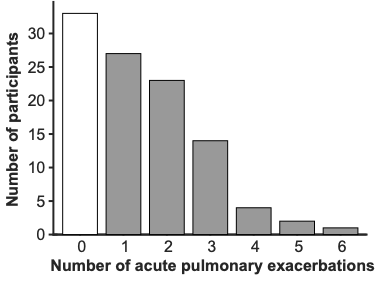

It turns out that the plots are not identical at all. Possible reasons for this
* Damian merged exacerbations that were "sequential"

**All individuals have an exacerbation... Why? Why didn't we get the original data?**

In [12]:
# From the patient data, get the ids list
import patient_data

df_patient_data = patient_data.load()
# Get the ids list
patient_ids = df_patient_data.ID.unique()


** Loading patient data **

* Dropping unnecessary columns from patient data *
Columns filtered: ['ID', 'Study Date', 'DOB', 'Age', 'Sex', 'Height', 'Weight', 'Predicted FEV1', 'FEV1 Set As']
Columns dropped: {'Unable Informed Consent', 'Unable Sputum Samples', 'Less Exacerbation', 'Date Last PE Stop', 'Freezer Required', 'Transplant Recipients', 'Study Number', 'Date Consent Obtained', 'Date Last PE Start', 'GP Letter Sent', 'Study Email', 'Telemetric Measures', 'Hospital', 'Sputum Samples', 'Comments', 'Inconvenience Payment', 'Remote Monitoring App User ID', 'Genetic Testing', 'Informed Consent', 'Age 18 Years', 'Pulmonary Exacerbation', 'CFQR Quest Comp'}

* Correcting patient data *
ID 60: Corrected height 60 from 1.63 to 163.0
ID 66: Corrected height for ID 66 from 1.62 to 162.0
Replace Age by calculate age
Drop FEV1 Set As and Predicted FEV1
Compute Calculated Predicted FEV1

* Applying data sanity checks *
Loaded patient data with 147 entries (147 initially)


/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning:

Unknown extension is not supported and will be removed



In [39]:
# Looking at the antibiotics data
# Let's try to reproduce this plot
import antibiotics_data

df_antibio = antibiotics_data.load()

# Compute number of antibiotics treatments per individua
df_n_antibio = (
    df_antibio.groupby("ID").size().reset_index(name="Number of antibiotics treatments")
)

# Get the list of ids that are in patient_ids but not in df_n_antibio
ids_not_in_antibio = np.setdiff1d(patient_ids, df_n_antibio.ID.unique())

print(
    "\nIDs list of individuals that did not have an antibiotics treatment (i.e. an exacerbation): \n{}".format(
        ids_not_in_antibio
    )
)

# Create dataframe with ids that did not have an antibiotics treatment and 0 antibiotics treatments
df_0_antibio = pd.DataFrame(
    {"ID": ids_not_in_antibio, "Number of antibiotics treatments": 0}
)

df_n_antibio = pd.concat([df_n_antibio, df_0_antibio], ignore_index=True)

# Add column with 0 when 0 antibiotic treatments, and 1 otherwise
df_n_antibio["Has ab"] = df_n_antibio["Number of antibiotics treatments"].apply(
    lambda x: 0 if x == 0 else 1
)

# Plot bar chart of count of individuals with n antibiotics treatments
fig = px.histogram(df_n_antibio, x="Number of antibiotics treatments", color="Has ab")
# Use categorical x axis
fig.update_xaxes(type="category")
# Order by x axis label
fig.update_layout(
    xaxis={"categoryorder": "array", "categoryarray": [str(i) for i in range(0, 30)]},
    autosize=False,
    width=800,
    height=400,
)
# Rename y axis to participants
fig.update_yaxes(title_text="Number of participants")
fig.show()


** Loading antibiotics data **

* Dropping unnecessary columns from antibiotics data *
Columns filetered: ['ID', 'Antibiotic Name', 'Route', "Home IV's'", 'Start Date', 'Stop Date']
Columns dropped: {'Study Number', 'Hospital', 'Antibiotic ID'}

IDs list of individuals that did not have an antibiotics treatment (i.e. an exacerbation): 
['101' '114' '121' '122' '124' '125' '126' '127' '128' '131' '134' '136'
 '142' '175' '180' '187' '197' '208' '209' '210' '213' '216' '223' '229'
 '236' '34' '40' '46' '52' '53' '54' '55' '57' '60' '61' '62' '63' '64'
 '65' '80' '81' '88' '93' '99']


/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning:

Unknown extension is not supported and will be removed



In [126]:
df_antibio

,ID,Antibiotic Name,Route,Home IV's',Start Date,Stop Date
0,138,Imipenem,Intravenous,No,2015-08-07,2015-08-12
1,138,Co-trimoxazole,Intravenous,No,2015-08-07,2015-08-12
2,138,Tigecycline,Intravenous,No,2015-08-07,2015-08-12
3,174,Rifampicin,PO,IP+OP,2015-08-17,2017-03-07
4,174,Clarithromycin,PO,IP+OP,2015-08-17,2017-03-07
...,...,...,...,...,...,...
580,200,Colomycin,IV,Yes,2017-03-20,2017-03-30
581,228,Meropenem,IV,Yes,2017-03-28,2017-04-03
582,228,Tobramycin,IV,Yes,2017-03-28,2017-04-03
583,202,Tobramycin,IV,No,2017-12-19,2017-02-22


In [127]:
df_pred

,ID,Date recorded,O2 Saturation,FEV1,Study Date,DOB,Age,Sex,Height,Weight,Predicted FEV1,FEV1 % Predicted,Is Exacerbated
0,23,2015-08-12,95.0,1.49,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265,66.921177,False
1,138,2015-08-14,94.0,1.30,2015-08-06,1985-10-31,30,Male,172.0,66.6,4.0360,32.210109,False
2,23,2015-08-14,95.0,1.29,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265,57.938468,False
3,23,2015-08-21,94.0,1.35,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265,60.633281,False
4,137,2015-08-26,95.0,1.28,2015-08-25,1976-05-24,39,Female,172.0,61.0,3.2190,39.763902,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,172,2017-03-23,95.0,0.81,2016-09-27,1991-06-18,25,Female,159.0,51.4,3.0555,26.509573,False
7991,179,2017-03-28,97.0,1.72,2016-10-21,1975-02-21,42,Female,168.0,57.9,2.9860,57.602143,False
7992,227,2017-04-01,95.0,1.99,2016-10-07,1970-05-15,46,Male,176.5,73.2,3.7655,52.848227,False
7993,229,2017-04-04,95.0,0.71,2016-10-27,1973-01-11,44,Female,151.0,50.0,2.2645,31.353500,False


#### Merging antibiotics with predictive classifier
* Are there right or left only IDs?

In [119]:
# Merging antibiotics with predictive classifier

# Add a column when the ID is in the list of IDs with stable but no ex labels
df_n_antibio["Only stable labels"] = df_n_antibio["ID"].isin(ids_stable_but_no_ex)

# Is there any na in the Stable but no ex column?
print(
    "Number of nan in the Stable but no ex column: {}".format(
        df_n_antibio["Only stable labels"].isna().sum()
    )
)

# Plot bar chart of count of individuals with n antibiotics treatments
fig = px.histogram(
    df_n_antibio,
    x="Number of antibiotics treatments",
    color="Only stable labels",
    barmode="stack",
)
# Use categorical x axis
fig.update_xaxes(type="category")
# Order by x axis label
fig.update_layout(
    xaxis={"categoryorder": "array", "categoryarray": [str(i) for i in range(1, 30)]}
)
# Rename y axis to participants
fig.update_yaxes(title_text="Number of participants")
fig.show()


Number of nan in the Stable but no ex column: 0


Learnings
* All pred labels correspond to an antibiotic treatment
* 

Are antibiotic treatment present in the pred labels?

In [115]:
# Count number of individuals with n antibiotics treatment
df.ID.tolist()

['100',
 '102',
 '107',
 '113',
 '115',
 '123',
 '129',
 '130',
 '132',
 '133',
 '135',
 '137',
 '138',
 '139',
 '140',
 '141',
 '143',
 '144',
 '151',
 '152',
 '153',
 '169',
 '170',
 '171',
 '172',
 '173',
 '174',
 '176',
 '177',
 '178',
 '179',
 '181',
 '182',
 '186',
 '188',
 '189',
 '190',
 '191',
 '192',
 '193',
 '194',
 '195',
 '196',
 '198',
 '199',
 '200',
 '201',
 '202',
 '203',
 '204',
 '205',
 '206',
 '207',
 '212',
 '214',
 '215',
 '227',
 '228',
 '23',
 '230',
 '231',
 '232',
 '233',
 '234',
 '235',
 '24',
 '241',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '35',
 '36',
 '37',
 '38',
 '39',
 '41',
 '42',
 '43',
 '44',
 '45',
 '47',
 '56',
 '58',
 '59',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '78',
 '79',
 '82',
 '92']

## Spread of O2 Saturation (IQR)

In [128]:
full = merge_pred_ex_labels_to(O2_FEV1, get_pred_ex_labels())
print(
    "{} IDs have measurements in exacerbation periods".format(
        full.ID[full["Is Exacerbated"] == True].nunique()
    )
)
print(
    "{} IDs have measurements in stable periods".format(
        full.ID[full["Is Exacerbated"] == False].nunique()
    )
)

nonan = full.dropna()

# Select only rows where isna is True
nan = full[full.isna().any(axis=1)]
full.head()


Exacerbated labels data from the predictive classifier has 14452 entries (1445 exacerbated, 13006 not exacerbated measurements, 1 NaN)
** Inner merge of O2_FEV1 and exacerbated labels on 'ID' and 'Date recorded' **
Data has now 7995 entries and 103 IDs (initially 9526 & 146 in O2_FEV1, 14452 in pred_ex_labels)
53 IDs have measurements in exacerbation periods
103 IDs have measurements in stable periods


,ID,Date recorded,O2 Saturation,FEV1,Study Date,DOB,Age,Sex,Height,Weight,Predicted FEV1,FEV1 % Predicted,Is Exacerbated
0,23,2015-08-12,95.0,1.49,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265,66.921177,False
1,138,2015-08-14,94.0,1.30,2015-08-06,1985-10-31,30,Male,172.0,66.6,4.0360,32.210109,False
2,23,2015-08-14,95.0,1.29,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265,57.938468,False
3,23,2015-08-21,94.0,1.35,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265,60.633281,False
4,137,2015-08-26,95.0,1.28,2015-08-25,1976-05-24,39,Female,172.0,61.0,3.2190,39.763902,False


In [129]:
# What's nan?

nan.head()

,ID,Date recorded,O2 Saturation,FEV1,Study Date,DOB,Age,Sex,Height,Weight,Predicted FEV1,FEV1 % Predicted,Is Exacerbated
3410,241,2016-04-25,87.0,1.12,2016-03-08,1992-09-16,23,Female,158.0,49.4,3.066,36.52968,NaN


In [130]:
# We'd like to plot the O2 saturation per ID to see the patterns at patient level

x_col = "Date recorded"

# Scatter plot nan with x Date recorded, y O2 saturation, color ID with px library
full_ex = full[full["Is Exacerbated"] == True]
print(full_ex.shape)


def set_axes(fig):
    # Set y axis range to min max of O2 saturation of full
    fig.update_yaxes(
        range=[full["O2 Saturation"].min() - 1, full["O2 Saturation"].max() + 1]
    )
    # Set x axis range to min max of Date recorded of full
    fig.update_xaxes(range=[full[x_col].min(), full[x_col].max()])
    return -1


fig = px.scatter(full_ex, x=x_col, y="O2 Saturation", color="ID")
set_axes(fig)
fig.add_shape(
    type="line",
    x0=full[x_col].min(),
    y0=95,
    x1=full[x_col].max(),
    y1=95,
    line=dict(color="Black", width=0.5),
)
fig.update_layout(
    title="Measurements in exacerbated period ({} points)".format(full_ex.shape[0])
)
fig.show()


(723, 13)


In [131]:
# There is a signal within the population for the measurements done during exacerbation periods
# Let's try to group individuals that have different behaviours during exacerbation periods.

# Plot patients by interquartile range of O2 saturation during exacerbation periods

# Plot a boxplot of the O2 saturation values by ID
fig = px.box(full, x="ID", y="O2 Saturation")
# Sort by mean O2 saturation
mean_o2 = full.groupby("ID")["O2 Saturation"].mean().sort_values()
fig.update_layout(xaxis={"categoryorder": "array", "categoryarray": mean_o2.index})
# Add title: Individual O2 saturation during exacerbation periods (number of IDs)
fig.update_layout(
    title="Individual O2 saturation during exacerbation periods ({} IDs)".format(
        full_ex["ID"].nunique()
    )
)
fig.show()


In [140]:
# 3 groups of patients can be identified:
# iqr < 94, i.e. max iqr < 94
# iqr in [94, 96], i.e. min iq >= 94 and max iqr <= 96
# iqr > 96, i.e. min iqr > 96

# Because of the data imbalance (much more recordings in stable period), the IQR min is often lower for stable than for ex, surprisingly.

# Let's plot distribution of O2 saturation for measurements made in ex and stable periods for each group


# Compute the interquartile range of O2 saturation during exacerbation periods
def get_upper_iqr_val(series):
    return series.quantile(0.75)


def get_lower_iqr_val(series):
    return series.quantile(0.25)


def get_median(series):
    return series.quantile(0.5)


def get_mean(series):
    return series.mean()


# Create a DataFrame with the interquartile range of O2 saturation during exacerbation periods for each patient
df_iqr_ex = (
    full[full["Is Exacerbated"] == True]
    .groupby("ID")["O2 Saturation"]
    .agg([get_upper_iqr_val, get_lower_iqr_val])
    .reset_index()
)
df_iqr_stable = (
    full[full["Is Exacerbated"] == False]
    .groupby("ID")["O2 Saturation"]
    .agg([get_upper_iqr_val, get_lower_iqr_val])
    .reset_index()
)

# Merge the two DataFrames - do an outer join to keep IDs with stable labels
df_iqr = df_iqr_ex.merge(
    df_iqr_stable, how="outer", on="ID", suffixes=("_ex", "_stable")
)

print("Number of IDs after merge: {}".format(df_iqr.shape[0]))

df_iqr["lower_iqr"] = df_iqr[["get_lower_iqr_val_ex", "get_lower_iqr_val_stable"]].min(
    axis=1
)
df_iqr["upper_iqr"] = df_iqr[["get_upper_iqr_val_ex", "get_upper_iqr_val_stable"]].max(
    axis=1
)
df_iqr["Median"] = (
    full.groupby("ID")["O2 Saturation"].agg(get_median).reset_index()["O2 Saturation"]
)
df_iqr["Mean"] = (
    full.groupby("ID")["O2 Saturation"].agg(get_mean).reset_index()["O2 Saturation"]
)
df_iqr.describe()


Number of IDs after merge: 103


,get_upper_iqr_val_ex,get_lower_iqr_val_ex,get_upper_iqr_val_stable,get_lower_iqr_val_stable,lower_iqr,upper_iqr,Median,Mean
count,53.000000,53.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,96.018868,94.721698,96.546117,95.077670,94.871359,96.618932,95.757282,95.699778
std,2.017263,2.325476,1.745003,1.961339,2.060323,1.717786,1.913400,1.820279
min,90.000000,88.000000,91.000000,89.000000,88.000000,91.000000,90.000000,89.580645
25%,95.000000,94.000000,95.250000,94.000000,93.875000,96.000000,95.000000,94.608403
50%,96.000000,95.000000,97.000000,95.000000,95.000000,97.000000,96.000000,96.200000
75%,97.750000,96.000000,98.000000,96.625000,96.000000,98.000000,97.000000,97.103013
max,99.000000,99.000000,99.000000,98.000000,98.000000,99.000000,98.500000,98.500000


In [141]:
def set_o2_sat_iqr(df):
    # Initialize O2 Sat IQR column
    df["O2 Sat IQR"] = ""
    # Set O2 Sat IQR to <94 if max iqr < 94
    df.loc[df["upper_iqr"] < 94, "O2 Sat IQR"] = "<94"
    # Set O2 Sat IQR to [94,96] if min iqr >= 94 and max iqr <= 96
    df.loc[(df["lower_iqr"] >= 94) & (df["upper_iqr"] <= 96), "O2 Sat IQR"] = "[94,96]"
    # Set O2 Sat IQR to >96 if min iqr > 96
    df.loc[df["lower_iqr"] > 96, "O2 Sat IQR"] = ">96"
    return df


df_iqr = set_o2_sat_iqr(df_iqr)

# Merge df_iqr 'O2 Sat IQR' with full on ID
full_iqr = full.merge(df_iqr[["ID", "O2 Sat IQR"]], on="ID", how="inner")

print(full_iqr.shape)
print("{} unique IDs in full_iqr".format(full_iqr.ID.nunique()))
full_iqr["O2 Sat IQR"].value_counts()
# Print number of IDs in each group
print(
    "{} IDs in group <94".format(full_iqr[full_iqr["O2 Sat IQR"] == "<94"].ID.nunique())
)
print(
    "{} IDs in group [94,96]".format(
        full_iqr[full_iqr["O2 Sat IQR"] == "[94,96]"].ID.nunique()
    )
)
print(
    "{} IDs in group >96".format(full_iqr[full_iqr["O2 Sat IQR"] == ">96"].ID.nunique())
)


(7995, 14)
103 unique IDs in full_iqr
6 IDs in group <94
16 IDs in group [94,96]
24 IDs in group >96


In [142]:
def set_o2_sat_mean(df, min_o2, type="Median"):
    # Initialize O2 Sat Mean column
    df["O2 Sat {}".format(type)] = ""
    # Set O2 Sat Mean to <94 if mean < 94
    df.loc[df[type] < min_o2, "O2 Sat {}".format(type)] = "<{}".format(min_o2)
    # Set O2 Sat Mean to [94,96] if mean >= 94 and mean <= 96
    df.loc[
        (df[type] >= min_o2) & (df[type] <= 96), "O2 Sat {}".format(type)
    ] = "[{},96]".format(min_o2)
    # Set O2 Sat Mean to >96 if mean > 96
    df.loc[df[type] > 96, "O2 Sat {}".format(type)] = ">96"
    return df


min_o2 = 93

df_iqr = set_o2_sat_mean(df_iqr, min_o2, type="Median")
full_iqr_2 = full_iqr.merge(df_iqr[["ID", "O2 Sat Median"]], on="ID", how="inner")

print("Median")
full_iqr_2["O2 Sat Median"].value_counts()
# Print number of IDs in each group
print(
    "{} IDs in group <{}".format(
        full_iqr_2[full_iqr_2["O2 Sat Median"] == "<{}".format(min_o2)].ID.nunique(),
        min_o2,
    )
)
print(
    "{} IDs in group [{},96]".format(
        full_iqr_2[
            full_iqr_2["O2 Sat Median"] == "[{},96]".format(min_o2)
        ].ID.nunique(),
        min_o2,
    )
)
print(
    "{} IDs in group >96".format(
        full_iqr_2[full_iqr_2["O2 Sat Median"] == ">96"].ID.nunique()
    )
)

df_iqr = set_o2_sat_mean(df_iqr, min_o2, type="Mean")
full_iqr_3 = full_iqr_2.merge(df_iqr[["ID", "O2 Sat Mean"]], on="ID", how="inner")

print("Mean")
full_iqr_3.head()
full_iqr_3["O2 Sat Mean"].value_counts()
# Print number of IDs in each group
print(
    "{} IDs in group {}".format(
        full_iqr_3[full_iqr_3["O2 Sat Mean"] == "<{}".format(min_o2)].ID.nunique(),
        min_o2,
    )
)
print(
    "{} IDs in group [{},96]".format(
        full_iqr_3[full_iqr_3["O2 Sat Mean"] == "[{},96]".format(min_o2)].ID.nunique(),
        min_o2,
    )
)
print(
    "{} IDs in group >96".format(
        full_iqr_3[full_iqr_3["O2 Sat Mean"] == ">96"].ID.nunique()
    )
)

full_iqr = full_iqr_3.copy()


Median
6 IDs in group <93
50 IDs in group [93,96]
47 IDs in group >96
Mean
10 IDs in group 93
35 IDs in group [93,96]
58 IDs in group >96


In [143]:
# For a small number of individuals, the base O2 saturation is low (<93) and the O2 saturation in exacerbation shifts even lower
# For most individuals, the base O2 saturation and the one in exacerbation have a similar distribution
# Question is there something wrong with 141?

col = "O2 Sat IQR"
col = "O2 Sat Median"
col = "O2 Sat Mean"

# Create figure with 3 rows and 1 column
fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    x_title="O2 saturation (%)",
    y_title="Probability",
    subplot_titles=(
        "iqr <{} ({} IDs)".format(
            min_o2, full_iqr[full_iqr[col] == "<{}".format(min_o2)]["ID"].nunique()
        ),
        "iqr in [{},96] ({} IDs)".format(
            min_o2, full_iqr[full_iqr[col] == "[{},96]".format(min_o2)]["ID"].nunique()
        ),
        "iqr >96 ({} IDs)".format(full_iqr[full_iqr[col] == ">96"]["ID"].nunique()),
    ),
)


# Compare the displots before and after removing the rows with nan
def distplot(df, fig, row, col):
    fig.add_trace(
        go.Histogram(
            x=df["O2 Saturation"][df["Is Exacerbated"] == True],
            histnorm="probability",
            marker=dict(color=get_ex_color()),
            name="Exacerbated",
        ),
        row=row,
        col=col,
    )
    fig.add_trace(
        go.Histogram(
            x=df["O2 Saturation"][df["Is Exacerbated"] == False],
            histnorm="probability",
            marker=dict(color=get_stable_color()),
            name="Stable",
        ),
        row=row,
        col=col,
    )
    # Add vertical gridlines x axis
    fig.update_xaxes(showgrid=True, gridwidth=1, row=row, col=col)
    fig.update_layout(barmode="overlay")
    return -1


distplot(full_iqr[full_iqr[col] == "<{}".format(min_o2)], fig, 1, 1)
distplot(full_iqr[full_iqr[col] == "[{},96]".format(min_o2)], fig, 2, 1)
distplot(full_iqr[full_iqr[col] == ">96"], fig, 3, 1)

fig.update_layout(
    width=800,
    height=800,
    title_text="Distribution of O2 saturation during exacerbation and stable periods",
)
fig.show()


# Create Factor Functions
We want the characterise the factor function that links the Unblocked FEV1 with its parents: Healthy FEV1 and Lung Damage. Here's a model of the relations betweeen those three varaibles: the unblocked FEV1 (L) of an individual is the healthy FEV1 (L), the theoretical lung function based on height, DOB, gdner, ethnicity (TBC exactly which), pejorated by the % in lung damage

## Lung damage for FEV1

In [36]:
# Factor function for unblocked FEV1 (L)
# This uses all the data from the O2_FEV1 table - without the exacerbation labels information


# Build unblocked factor dataframe
def compute_unblocked_factor(O2_FEV1):
    df = pd.DataFrame(
        columns=["ID", "Unblocked FEV1 (L)", "Lung Damage (%)", "Healthy FEV1 (L)"]
    )
    for id in O2_FEV1.ID.unique():
        # For a given patient id, filter the FEV1 measurements
        mask = O2_FEV1["ID"] == id
        O2_FEV1_patient = O2_FEV1[mask]
        # Find the unblocked FEV1 (L). We assume that, over the 6 months study period, the patient has done some measurements where he was not blocked
        # To avoid taking an outlier up, which is third highest FEV1 measurement
        rmax = O2_FEV1_patient["FEV1"].nlargest(3).iloc[-1]
        # Get the theoretical healthy FEV1 (L)
        healthy_fev1 = O2_FEV1_patient["Predicted FEV1"].iloc[0]
        # Compute the Lung damage (%)
        lung_damage = 100 * (1 - rmax / healthy_fev1)
        # Add the patient id, reversed max FEV1 and healthy FEV1 (L) to the dataframe
        new_row = pd.DataFrame(
            {
                "ID": [id],
                "Unblocked FEV1 (L)": [rmax],
                "Lung Damage (%)": [lung_damage],
                "Healthy FEV1 (L)": [healthy_fev1],
            }
        )
        df = pd.concat([df, new_row])
    return df


df_unblocked_factor = compute_unblocked_factor(O2_FEV1)
# Add patient data to the unblocked factor table
df_unblocked_factor = pd.merge(
    df_unblocked_factor, patient_data.load(), on="ID", how="left"
)
df_unblocked_factor.head()



** Loading patient data **

* Dropping unnecessary columns from patient data *
Columns filtered: ['ID', 'Study Date', 'DOB', 'Age', 'Sex', 'Height', 'Weight', 'Predicted FEV1', 'FEV1 Set As']
Columns dropped: {'Remote Monitoring App User ID', 'Genetic Testing', 'Hospital', 'Study Number', 'Telemetric Measures', 'Date Last PE Start', 'CFQR Quest Comp', 'Age 18 Years', 'GP Letter Sent', 'Informed Consent', 'Pulmonary Exacerbation', 'Sputum Samples', 'Study Email', 'Inconvenience Payment', 'Unable Sputum Samples', 'Date Last PE Stop', 'Transplant Recipients', 'Comments', 'Freezer Required', 'Less Exacerbation', 'Unable Informed Consent', 'Date Consent Obtained'}

* Correcting patient data *
ID 60: Corrected height 60 from 1.63 to 163.0
ID 66: Corrected height for ID 66 from 1.62 to 162.0
Replace Age by calculate age
Drop FEV1 Set As and Predicted FEV1
Compute Calculated Predicted FEV1

* Applying data sanity checks *
Loaded patient data with 147 entries (147 initially)


/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning:

Unknown extension is not supported and will be removed



,ID,Unblocked FEV1 (L),Lung Damage (%),Healthy FEV1 (L),Study Date,DOB,Age,Sex,Height,Weight,Predicted FEV1
0,23,1.65,25.892657,2.2265,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265
1,138,1.35,66.551041,4.0360,2015-08-06,1985-10-31,30,Male,172.0,66.6,4.0360
2,137,1.52,52.780367,3.2190,2015-08-25,1976-05-24,39,Female,172.0,61.0,3.2190
3,81,1.65,52.843670,3.4990,2015-08-25,1965-11-08,50,Male,173.0,65.3,3.4990
4,24,2.74,17.767107,3.3320,2015-08-06,1990-11-25,25,Female,166.0,74.2,3.3320


In [188]:
# Plot a scatter of unblocked FEV1 (L) against healthy FEV1 (L)
def scatter_lung_damage(df, write=False, subsampled=False):
    fig = px.scatter(
        df,
        x="Healthy FEV1 (L)",
        y="Lung Damage (%)",
        color="Age",
        # color_continuous_scale='RdBu')
        color_continuous_scale="YlGnBu",
    )
    # color_continuous_scale='deep')
    fig.add_shape(
        type="line",
        x0=df["Healthy FEV1 (L)"].min(),
        y0=0,
        x1=df["Healthy FEV1 (L)"].max(),
        y1=0,
        line=dict(color="Black", width=1),
    )
    title = "Impact of lung damage on healthy FEV1 ({} points{})".format(
        df.shape[0], ", subsampled" if subsampled else ""
    )
    fig.update_layout(
        autosize=False, width=500, height=500, title=title, title_font_size=15
    )
    fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
    fig.show()
    # Save figure
    fig.write_image(
        "{}/Factors - {}.pdf".format(plotsdir, title), width=500, height=500
    )


scatter_lung_damage(df_unblocked_factor)
# Observations:
# Looks like a classic uncorrelated scatter plot
# It's great because it shows that our factors are not correlated with each other
# We rotated the scatter plot by 45 degrees to see if there was a correlation between lung damage and healthy FEV1
# There might be a correlation with age, let's have a look at it.


In [186]:
# Plot a scatter of Lung Damage (%) against Age
fig = px.scatter(df_unblocked_factor, x="Age", y="Lung Damage (%)")
fig.add_shape(
    type="line",
    x0=df_unblocked_factor["Age"].min(),
    y0=0,
    x1=df_unblocked_factor["Age"].max(),
    y1=0,
    line=dict(color="Black", width=1),
)
title = "Impact of lung damage on age ({} points)".format(df_unblocked_factor.shape[0])
fig.update_layout(autosize=False, width=500, height=500, title=title)
fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
fig.show()

# Expectations:
# We're looking at a population, not an individual. Hence, we expect a possible correlation to be weak

# Observations:
# 60 years, 0% lung damage. Let's see who that is - maybe we're the linear approximation is not good enough - it looks ok
# It can seem that lung damage diminishes with age...
# Huge difference in data density. We have a lot of data for young people, and very few for old people, they died unfortunately


In [189]:
def box_lung_damage_age(df, write=False, subsampled=False):
    # Same but grouping by age group; #pointss
    print(df["Age"].describe())
    df["Age Group; #points"] = pd.cut(
        df["Age"].values,
        bins=[18, 30, 40, 50, 66],
        labels=["18-30", "30-40", "40-50", "50-66"],
    )
    print(df["Age Group; #points"].value_counts())
    # Rename the Age Group; #points value '18-30' to '18-29'
    df["Age Group; #points"] = df["Age Group; #points"].replace(
        "18-30", "18-30; {}".format(df["Age Group; #points"].value_counts()["18-30"])
    )
    df["Age Group; #points"] = df["Age Group; #points"].replace(
        "30-40", "30-40; {}".format(df["Age Group; #points"].value_counts()["30-40"])
    )
    df["Age Group; #points"] = df["Age Group; #points"].replace(
        "40-50", "40-50; {}".format(df["Age Group; #points"].value_counts()["40-50"])
    )
    df["Age Group; #points"] = df["Age Group; #points"].replace(
        "50-66", "50-66; {}".format(df["Age Group; #points"].value_counts()["50-66"])
    )
    # Sort by age group, #points
    df = df.sort_values(by=["Age Group; #points"])

    # Plot a boxplot of Lung Damage (%) against Age
    fig = px.box(df, x="Age Group; #points", y="Lung Damage (%)")
    title = "Impact of lung damage on age ({} points{})".format(
        df.shape[0], ", subsampled" if subsampled else ""
    )
    fig.update_layout(
        autosize=False, width=500, height=500, title=title, title_font_size=15
    )
    fig.show()
    fig.write_image(
        "{}/Factors - {}.pdf".format(plotsdir, title), width=500, height=500
    )
    return -1


box_lung_damage_age(df_unblocked_factor)


count    146.000000
mean      31.636986
std        9.336528
min       18.000000
25%       24.000000
50%       30.000000
75%       37.000000
max       66.000000
Name: Age, dtype: float64
18-30    70
30-40    48
40-50    20
50-66     4
Name: Age Group; #points, dtype: int64


-1

In [195]:
# Plot a subsampled version of the above plot

df = df_unblocked_factor
# Sub sample df so that there's randomly 20 points per age group
df_unblocked_factor_subampled_age = df.groupby(
    "Age Group; #points", group_keys=False
).apply(lambda x: x.sample(min(len(x), 20)))

print(
    "Initial shape {}, subsampled shape {}".format(
        df_unblocked_factor.shape, df_unblocked_factor_subampled_age.shape
    )
)

box_lung_damage_age(df_unblocked_factor_subampled_age, subsampled=True)
scatter_lung_damage(df_unblocked_factor_subampled_age, subsampled=True)


Initial shape (146, 12), subsampled shape (64, 12)
count    64.000000
mean     36.484375
std      10.516793
min      19.000000
25%      28.750000
50%      36.000000
75%      44.000000
max      66.000000
Name: Age, dtype: float64
18-30    20
30-40    20
40-50    20
50-66     4
Name: Age Group; #points, dtype: int64


## Small airway blockage for FEV1

In [42]:
df_blockage_factor = merge_pred_ex_labels_to(O2_FEV1, get_pred_ex_labels())

df_unblocked_factor = compute_unblocked_factor(O2_FEV1).drop(
    columns=["Lung Damage (%)", "Healthy FEV1 (L)"]
)

# Left join df_blockage_factor with df_unblocked_factor on ID
df_blockage_factor = pd.merge(
    df_blockage_factor, df_unblocked_factor, on="ID", how="left"
)
df_blockage_factor["Small Airway Blockage (%)"] = (
    1 - df_blockage_factor.FEV1 / df_blockage_factor["Unblocked FEV1 (L)"]
) * 100

# Sort values by Unblocked FEV1 (L)
df_blockage_factor = df_blockage_factor.sort_values(by=["Unblocked FEV1 (L)"])

# Plot unblocked fev1 (L) in x, measured fev1 in y, and color by Is Exacerbated
fig = px.scatter(
    df_blockage_factor,
    x="ID",
    y="Small Airway Blockage (%)",
    color="Is Exacerbated",
    color_discrete_sequence=[get_stable_color(0.2), get_ex_color(0.2)],
)
title = "Impact of % small airways blockage on unblocked FEV1 ({} points)".format(
    df_blockage_factor.shape[0]
)
fig.update_layout(autosize=False, width=1300, height=600, title=title)


# Add scatter plot with marker lines of the Unblocked FEV1 (L) values on a new y axis
# Get df_unblocked_factor with only the IDs present in df_blockage_factor
df_unblocked_with_pred_ids = df_unblocked_factor[
    df_unblocked_factor["ID"].isin(df_blockage_factor["ID"])
]
# Put this trace on a new y axis
fig.update_layout(yaxis2=dict(overlaying="y", side="right", title="Unblocked FEV1 (L)"))

## THE TRACE BELOW ADDS A BLACK MARK FOR EACH INDIVIDUAL'S UNBLOCKED FEV1 (L) VALUE
## WE REMOVED IT BECAUSE IT GIVES MORE NOISE THAN INFORMATION
# # Plot the Unblocked FEV1 (L) values on the new y axis
# fig.add_trace(
#     go.Scatter(
#         x=df_unblocked_with_pred_ids["ID"],
#         y=df_unblocked_with_pred_ids["Unblocked FEV1 (L)"],
#         mode="markers",
#         marker=dict(symbol="line-ew", color="black", line=dict(width=1)),
#         yaxis="y2",
#     )
# )
# # Hide legend for this trace
# fig.update_traces(showlegend=False, selector=dict(yaxis="y2"))


fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
# Reduce x axis tick labels size
fig.update_xaxes(tickfont=dict(size=7))
fig.show()
# Save figure
fig.write_image("{}/Factors - {}.pdf".format(plotsdir, title))

# Expectations:
# Measurements done in exacerbated period are related to a higher % of airway blockage
# The higher the unblocked FEV1, the sicker the people = more likely to be in permanent inflammatory state = the higher the % of airway blockage

# Observations:
#


Exacerbated labels data from the predictive classifier has 14452 entries (1445 exacerbated, 13006 not exacerbated measurements, 1 NaN)
** Inner merge of O2_FEV1 and exacerbated labels on 'ID' and 'Date recorded' **
Data has now 7995 entries and 103 IDs (initially 9526 & 146 in O2_FEV1, 14452 in pred_ex_labels)


## Lung damage for O2 saturation

In [51]:
# Assumptions
# Normal Pa O2 is constantly 100%
# Unblocked Pa O2 is the reverse max of O2 saturations measured


# Build unblocked factor dataframe
def compute_unblocked_factor(O2_FEV1):
    df = pd.DataFrame(
        columns=[
            "ID",
            "Unblocked O2 Saturation (%)",
            "Lung Damage (%)",
            "Healthy O2 Saturation (%)",
        ]
    )
    for id in O2_FEV1.ID.unique():
        # For a given patient id, filter the O2 Saturation measurements
        mask = O2_FEV1["ID"] == id
        O2_FEV1_patient = O2_FEV1[mask]
        # Find the unblocked O2 Saturation (%). We assume that, over the 6 months study period, the patient has done some measurements where he was not blocked
        # To avoid taking an outlier up, which is third highest O2 Saturation measurement
        rmax = O2_FEV1_patient["O2 Saturation"].nlargest(3).iloc[-1]
        # Theoretical O2 saturation is 100%
        healthy_o2_sat = 100
        # Compute the Lung damage (%)
        lung_damage = 100 - rmax  # 100 * (1-rmax/healthy_o2_sat)
        # Add the patient id, reversed max O2 Saturation and healthy O2 Saturation (%) to the dataframe
        new_row = pd.DataFrame(
            {
                "ID": [id],
                "Unblocked O2 Saturation (%)": [rmax],
                "Lung Damage (%)": [lung_damage],
                "Healthy O2 Saturation (%)": [healthy_o2_sat],
            }
        )
        df = pd.concat([df, new_row])
    return df


df_unblocked_factor = compute_unblocked_factor(O2_FEV1)
# Add patient data to the unblocked factor table
df_unblocked_factor = pd.merge(
    df_unblocked_factor, patient_data.load(), on="ID", how="left"
)
df_unblocked_factor.head()



** Loading patient data **

* Dropping unnecessary columns from patient data *
Columns filtered: ['ID', 'Study Date', 'DOB', 'Age', 'Sex', 'Height', 'Weight', 'Predicted FEV1', 'FEV1 Set As']
Columns dropped: {'Inconvenience Payment', 'Less Exacerbation', 'Transplant Recipients', 'Sputum Samples', 'Remote Monitoring App User ID', 'Date Last PE Stop', 'GP Letter Sent', 'Unable Sputum Samples', 'Informed Consent', 'Pulmonary Exacerbation', 'Unable Informed Consent', 'Freezer Required', 'Age 18 Years', 'Comments', 'Date Consent Obtained', 'Hospital', 'CFQR Quest Comp', 'Date Last PE Start', 'Study Email', 'Study Number', 'Telemetric Measures', 'Genetic Testing'}

* Correcting patient data *
ID 60: Corrected height 60 from 1.63 to 163.0
ID 66: Corrected height for ID 66 from 1.62 to 162.0
Replace Age by calculate age
Drop FEV1 Set As and Predicted FEV1
Compute Calculated Predicted FEV1

* Applying data sanity checks *
Loaded patient data with 147 entries (147 initially)


/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning:

Unknown extension is not supported and will be removed



,ID,Unblocked O2 Saturation (%),Lung Damage (%),Healthy O2 Saturation (%),Study Date,DOB,Age,Sex,Height,Weight,Predicted FEV1
0,23,98.0,2.0,100,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265
1,138,95.0,5.0,100,2015-08-06,1985-10-31,30,Male,172.0,66.6,4.0360
2,137,98.0,2.0,100,2015-08-25,1976-05-24,39,Female,172.0,61.0,3.2190
3,81,98.0,2.0,100,2015-08-25,1965-11-08,50,Male,173.0,65.3,3.4990
4,24,99.0,1.0,100,2015-08-06,1990-11-25,25,Female,166.0,74.2,3.3320


In [54]:
fig = px.scatter(
    df_unblocked_factor,
    x="Age",
    y="Lung Damage (%)",
    color="Sex",
    color_continuous_scale="YlGnBu",
)
fig.add_shape(
    type="line",
    x0=df_unblocked_factor["Healthy O2 Saturation (%)"].min(),
    y0=0,
    x1=df_unblocked_factor["Healthy O2 Saturation (%)"].max(),
    y1=0,
    line=dict(color="Black", width=1),
)
title = "Impact of lung damage on healthy O2 Sat ({} points)".format(
    df_unblocked_factor.shape[0]
)
fig.update_layout(autosize=False, width=700, height=500, title=title)
fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
fig.show()
# Save figure
fig.write_image("{}/Factors - {}.pdf".format(plotsdir, title), width=500, height=500)


## Small airway blockage for O2 saturation

In [58]:
df_blockage_factor = merge_pred_ex_labels_to(O2_FEV1, get_pred_ex_labels())

df_unblocked_factor = compute_unblocked_factor(O2_FEV1).drop(
    columns=["Lung Damage (%)", "Healthy O2 Saturation (%)"]
)

# Left join df_blockage_factor with df_unblocked_factor on ID
df_blockage_factor = pd.merge(
    df_blockage_factor, df_unblocked_factor, on="ID", how="left"
)
df_blockage_factor["Airway Blockage (%)"] = (
    1
    - df_blockage_factor["O2 Saturation"]
    / df_blockage_factor["Unblocked O2 Saturation (%)"]
) * 100

# Sort values by Unblocked O2 Saturation (%)
df_blockage_factor = df_blockage_factor.sort_values(by=["Unblocked O2 Saturation (%)"])

# Plot Unblocked O2 Saturation (%) in x, measured fev1 in y, and color by Is Exacerbated
fig = px.scatter(
    df_blockage_factor,
    x="ID",
    y="Airway Blockage (%)",
    color="Is Exacerbated",
    color_discrete_sequence=[get_stable_color(0.2), get_ex_color(0.2)],
)
title = "Impact of % small airways blockage on unblocked O2 Sat ({} points)".format(
    df_blockage_factor.shape[0]
)
fig.update_layout(autosize=False, width=1300, height=600, title=title)


# Add scatter plot with marker lines of the Unblocked O2 Saturation (%) values on a new y axis
# Get df_unblocked_factor with only the IDs present in df_blockage_factor
df_unblocked_with_pred_ids = df_unblocked_factor[
    df_unblocked_factor["ID"].isin(df_blockage_factor["ID"])
]
# Put this trace on a new y axis
fig.update_layout(
    yaxis2=dict(overlaying="y", side="right", title="Unblocked O2 Saturation (%)")
)
# Plot the Unblocked O2 Saturation (%) values on the new y axis
fig.add_trace(
    go.Scatter(
        x=df_unblocked_with_pred_ids["ID"],
        y=df_unblocked_with_pred_ids["Unblocked O2 Saturation (%)"],
        mode="markers",
        marker=dict(symbol="line-ew", color="black", line=dict(width=1)),
        yaxis="y2",
    )
)
# Hide legend for this trace
fig.update_traces(showlegend=False, selector=dict(yaxis="y2"))


fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
# Reduce x axis tick labels size
fig.update_xaxes(tickfont=dict(size=7))
fig.show()
# Save figure
fig.write_image("{}/Factors - {}.pdf".format(plotsdir, title))

# Expectations:
# Measurements done in exacerbated period are related to a higher % of airway blockage
# The higher the unblocked FEV1, the sicker the people = more likely to be in permanent inflammatory state = the higher the % of airway blockage

# Observations:
#


Exacerbated labels data from the predictive classifier has 14452 entries (1445 exacerbated, 13006 not exacerbated measurements, 1 NaN)
** Inner merge of O2_FEV1 and exacerbated labels on 'ID' and 'Date recorded' **
Data has now 7995 entries and 103 IDs (initially 9526 & 146 in O2_FEV1, 14452 in pred_ex_labels)


## O2 sat grouped by  vs lung damage

In [ ]:
# Group O2 sat by IQR


## Archive

In [17]:
# Factor function for unblocked FEV1 (L)
df_unblocked_factor = pd.DataFrame(
    columns=["ID,", "Unblocked FEV1 (L)", "Healthy FEV1 (L)"]
)
for id in O2_FEV1.ID.unique():
    # For a given patient id, filter the FEV1 measurements
    mask = O2_FEV1["ID"] == id
    O2_FEV1_patient = O2_FEV1[mask]
    # Find the unblocked FEV1 (L). We assume that, over the 6 months study period, the patient has done some measurements where he was not blocked
    # To avoid taking an outlier up, which is third highest FEV1 measurement
    rmax = O2_FEV1_patient["FEV1"].nlargest(3).iloc[-1]
    # Get the theoretical healthy FEV1 (L)
    healthy_fev1 = O2_FEV1_patient["Predicted FEV1"].iloc[0]
    # Add the patient id, reversed max FEV1 and healthy FEV1 (L) to the dataframe
    new_row = pd.DataFrame(
        {"ID": [id], "Unblocked FEV1 (L)": [rmax], "Healthy FEV1 (L)": [healthy_fev1]}
    )
    df_unblocked_factor = pd.concat([df_unblocked_factor, new_row])


def add_lung_damage(fig, df, lung_damage_prct):
    xmax = df["Healthy FEV1 (L)"].max()
    xmin = df["Healthy FEV1 (L)"].min()
    a = 1 - lung_damage_prct / 100
    fig.add_shape(
        type="line",
        x0=xmin,
        y0=a * xmin,
        x1=xmax,
        y1=a * xmax,
        line=dict(color="Red", width=0.5),
    )
    # Add line legend for no lung damage
    fig.add_annotation(
        x=1.02 * xmax,
        y=a * xmax,
        text="{}%".format(lung_damage_prct),
        showarrow=False,
        font=dict(size=10, color="Red"),
    )


# Plot a scatter of unblocked FEV1 (L) against healthy FEV1 (L)
fig = px.scatter(df_unblocked_factor, x="Healthy FEV1 (L)", y="Unblocked FEV1 (L)")
add_lung_damage(fig, df_unblocked_factor, 0)
add_lung_damage(fig, df_unblocked_factor, 50)
title = "Impact of lung damage on healthy FEV1 ({} points)".format(
    df_unblocked_factor.shape[0]
)
fig.update_layout(autosize=False, width=500, height=500, title=title)
fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
fig.show()
# Save figure
fig.write_image("{}/Factors - {}.pdf".format(plotsdir, title), width=500, height=500)


In [25]:
df_blockage_factor = merge_pred_ex_labels_to(O2_FEV1, get_pred_ex_labels())

df_unblocked_factor = pd.DataFrame(
    columns=["ID,", "Unblocked FEV1 (L)", "Healthy FEV1 (L)"]
)
for id in O2_FEV1.ID.unique():
    # For a given patient id, filter the FEV1 measurements
    mask = O2_FEV1["ID"] == id
    O2_FEV1_patient = O2_FEV1[mask]
    # Find the unblocked FEV1 (L). We assume that, over the 6 months study period, the patient has done some measurements where he was not blocked
    # To avoid taking an outlier up, which is third highest FEV1 measurement
    rmax = O2_FEV1_patient["FEV1"].nlargest(3).iloc[-1]
    # Get the theoretical healthy FEV1 (L)
    healthy_fev1 = O2_FEV1_patient["Predicted FEV1"].iloc[0]
    # Add the patient id, reversed max FEV1 and healthy FEV1 (L) to the dataframe
    new_row = pd.DataFrame(
        {"ID": [id], "Unblocked FEV1 (L)": [rmax], "Healthy FEV1 (L)": [healthy_fev1]}
    )
    df_unblocked_factor = pd.concat([df_unblocked_factor, new_row])

# Left join df_blockage_factor with df_unblocked_factor on ID
df_blockage_factor = pd.merge(
    df_blockage_factor, df_unblocked_factor, on="ID", how="left"
)

# Plot unblocked fev1 (L) in x, measured fev1 in y, and color by Is Exacerbated
fig = px.scatter(
    df_blockage_factor,
    x="Unblocked FEV1 (L)",
    y="FEV1",
    color="Is Exacerbated",
    color_discrete_sequence=[get_stable_color(0.3), get_ex_color(0.3)],
)
title = "Impact of % small airways blockage on unblocked FEV1 ({} points)".format(
    df_blockage_factor.shape[0]
)
fig.update_layout(autosize=False, width=800, height=800, title=title)
fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
fig.show()
# Save figure
fig.write_image("{}/Factors - {}.pdf".format(plotsdir, title))


Exacerbated labels data from the predictive classifier has 14452 entries (1445 exacerbated, 13006 not exacerbated measurements, 1 NaN)
** Inner merge of O2_FEV1 and exacerbated labels on 'ID' and 'Date recorded' **
Data has now 7996 entries and 103 IDs (initially 9527 & 146 in O2_FEV1, 14452 in pred_ex_labels)
